In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.feature_selection import SelectFromModel, RFECV
import joblib
import os
from utils import one_hot_encode_columns, train_rf_with_gridsearch
from scipy.stats import norm

In [2]:
anes = 'anes_preprocessed_data.csv'
anes_df = pd.read_csv(anes, low_memory=False)
anes_df = anes_df[['state', 'gender', 'race', 'age_group', 'edu', 'income', 'vote']]

In [3]:
categorical_columns = ['state', 'gender', 'race']

# perform one-hot encoding on the categorical column
categorical_columns = ['state', 'gender', 'race']
anes_df = one_hot_encode_columns(anes_df, categorical_columns)

In [4]:
X = anes_df.drop(['vote'], axis=1)
y = anes_df['vote']

In [5]:
# 80% train+val, 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 25% of 80% = 20% val
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}")

Training set size: (3903, 64), Validation set size: (1301, 64), Test set size: (1301, 64)


In [6]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features':[3 ,5, 7, 9, 11],
    'max_depth': [3, 5, 7],
    'min_samples_split': [3, 5, 7, 10],
    'min_samples_leaf': [3, 5, 7]
}
best_rf, feature_importance, val_report, best_params = train_rf_with_gridsearch(X_train, y_train, X_val, y_val, param_grid)

Fitting 2 folds for each of 540 candidates, totalling 1080 fits
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END ma

In [7]:
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 7, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [8]:
val_report_df = pd.DataFrame(val_report).T
val_report_df

,precision,recall,f1-score,support
1,0.699871,0.729111,0.714191,742.000000
2,0.619318,0.584973,0.601656,559.000000
accuracy,0.667179,0.667179,0.667179,0.667179
macro avg,0.659594,0.657042,0.657924,1301.000000
weighted avg,0.665260,0.667179,0.665838,1301.000000


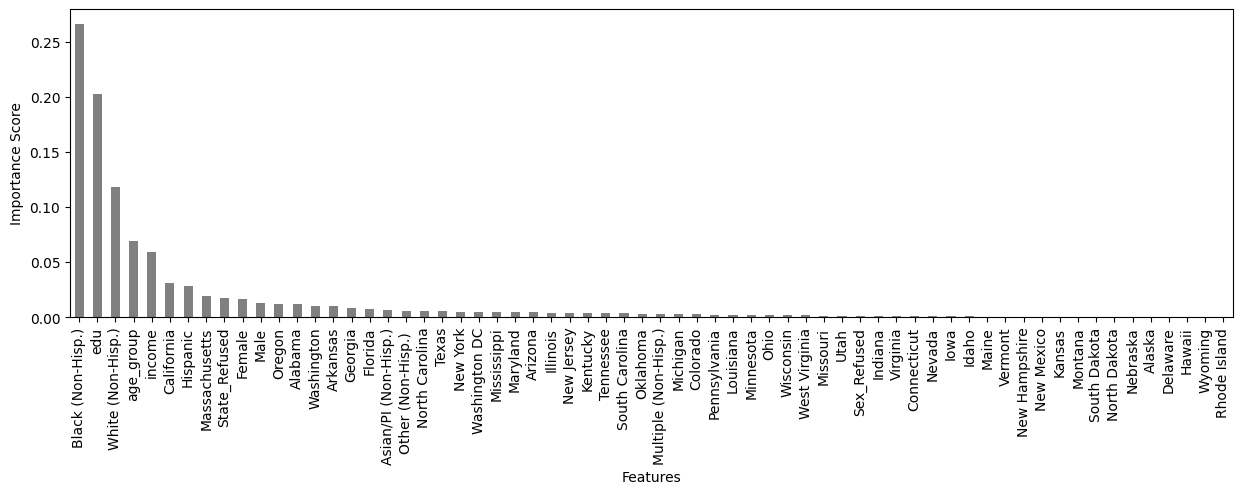

In [9]:
feature_importance.plot(kind='bar', figsize=(15, 4), color='gray')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

In [10]:
# Save model
os.makedirs('models', exist_ok=True)
joblib.dump(best_rf, 'models/baseline_model.pkl')

['models/baseline_model.pkl']

In [11]:
# Predict and evaluate on the test set
y_test_pred = best_rf.predict(X_test)
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
test_report_df = pd.DataFrame(test_report).T
test_report_df

Test Accuracy: 0.6479631053036126


,precision,recall,f1-score,support
1,0.676585,0.715458,0.695479,731.000000
2,0.606061,0.561404,0.582878,570.000000
accuracy,0.647963,0.647963,0.647963,0.647963
macro avg,0.641323,0.638431,0.639178,1301.000000
weighted avg,0.645686,0.647963,0.646146,1301.000000


In [ ]:
# Calculate 95% confidence interval for the test accuracy
n = len(y_test)
z = norm.ppf(0.975)  # 1.96 for 95% confidence
se = np.sqrt((test_accuracy * (1 - test_accuracy)) / n)
margin_of_error = z * se

print(f"Test Accuracy: {test_accuracy:.3f} ± {margin_of_error:.3f} (95% CI)")
print(f"95% CI: [{test_accuracy - margin_of_error:.3f}, {test_accuracy + margin_of_error:.3f}]")

Test Accuracy: 0.648 ± 0.026 (95% CI)
95% CI: [0.622, 0.674]
